In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import torch
import torch.nn as nn
import json

from feature_extractor import FeatureExtractor

## get label distribution

In [3]:
anno_dict = pickle.load(open('/workspace/pvc-meteor/features/annotations.pickle', 'rb'))
anno_dict['REC_2020_10_12_03_08_38_F.MP4']['feature_length'] == anno_dict['REC_2020_10_12_03_08_38_F.MP4']['anno'].shape[0]

True

In [4]:
total_frames = 0
cat_array = np.zeros((7,))
unannoted_frames = 0

for name in tqdm(anno_dict.keys()):
    total_frames += anno_dict[name]['feature_length']
    annotation = anno_dict[name]['anno']
    new_cat = np.sum(annotation, axis=0)
    unannoted_frames += anno_dict[name]['feature_length'] - np.any(annotation, axis=1).sum()

    cat_array = cat_array + new_cat


100%|██████████| 1213/1213 [00:00<00:00, 15346.84it/s]


In [5]:
cat_list = cat_array.tolist()
cat_list[2] - total_frames

-895175.0

In [6]:
cat_names = ['Over Taking', 'Over Speedign', 'Lane Change', 'Traffic Light', 'Wrong Lane', 'Wrong Turn', 'Cutting']

cat_list, total_frames, unannoted_frames

([281774.0, 342.0, 90571.0, 518.0, 36512.0, 213.0, 9482.0], 985746, 622239)

### generate `pos_weight` for `torch.nn.BCEWithLogitsLoss`

In [7]:
df = pd.DataFrame(
    data=cat_list,
    columns=['frames_per_cat'],
    index=cat_names
    )
df = (df
    .assign(frames_not_cat = total_frames - df.iloc[:,0])
    .assign(weight = df.iloc[:, -1] / df.iloc[:, 0])
    )
df

,frames_per_cat,frames_not_cat,weight
Over Taking,281774.0,703972.0,1.0
Over Speedign,342.0,985404.0,1.0
Lane Change,90571.0,895175.0,1.0
Traffic Light,518.0,985228.0,1.0
Wrong Lane,36512.0,949234.0,1.0
Wrong Turn,213.0,985533.0,1.0
Cutting,9482.0,976264.0,1.0


In [8]:
torch.tensor(df.weight.values)

tensor([1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64)

## visualize class distribution

Text(0.5, 1.0, 'Distribution of frames per category, Logscaled')

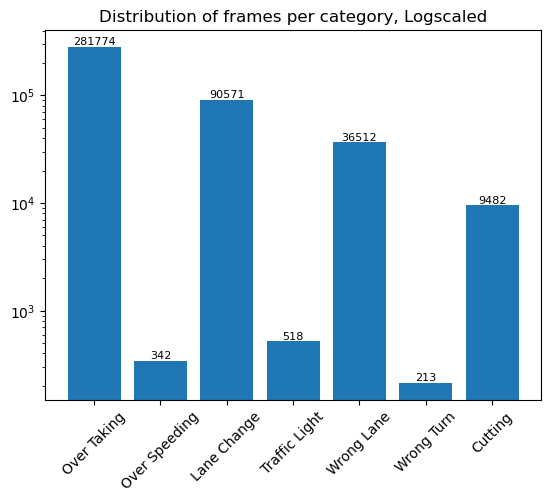

In [28]:
fig = plt.figure()

ax = fig.add_subplot(1,1,1)
ax.set_yscale('log')
cat_names = ['Over Taking', 'Over Speeding', 'Lane Change', 'Traffic Light', 'Wrong Lane', 'Wrong Turn', 'Cutting']


ax.bar(cat_names, cat_list)

# Add annotations to each bar
for bar in ax.patches:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, 
            str(int(height)),
            ha='center', va='bottom', rotation=0, color='black', fontsize=8)

plt.xticks(rotation = 45)
plt.title('Distribution of frames per category, Logscaled')

### analyse test and train set seperately.

In [34]:
json_file = json.load(open('../../pvc-meteor/features/METEOR_info.json', 'r'))['METEOR']

In [35]:
train_vid_names = json_file['train_session_set']
test_vid_names = json_file['test_session_set']

test_class_counts = np.zeros((7))
for vid_name in test_vid_names:
    curr_anno = anno_dict[vid_name]['anno']

    test_class_counts = test_class_counts + np.sum(curr_anno, axis=0)
    
train_class_counts = np.zeros((7))
for vid_name in train_vid_names:
    curr_anno = anno_dict[vid_name]['anno']

    train_class_counts = train_class_counts + np.sum(curr_anno, axis=0) 

,test,train
OverTaking,57700.0,224074.0
Overspeeding,0.0,342.0
LaneChange,17235.0,73336.0
TrafficLight,0.0,518.0
WrongLane,6373.0,30139.0
WrongTurn,36.0,177.0
Cutting,1998.0,7484.0


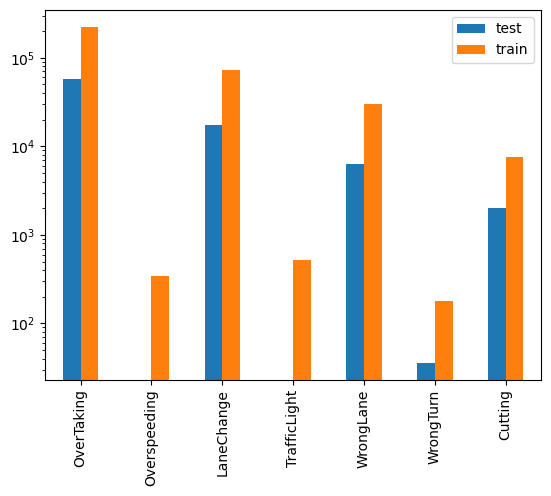

In [36]:
df = pd.DataFrame(
    data=np.column_stack((test_class_counts, train_class_counts)),
    columns=['test_f', 'train_f'],
    index = json_file['class_index']
)

ax = df.plot(kind='bar', stacked=False)
ax.set_yscale('log')

df

### find split so that all classes are part of both sets.

- count frames per class per video
- select videos so that 20% of each class are part of test set. Rest is train.

In [37]:
def more_perfect_split(data, test_split = 0.2):
    out_df = pd.DataFrame(data=None, columns=['Over Taking', 'Over Speeding', 'Lane Change', 'Traffic Light', 'Wrong Lane', 'Wrong Turn', 'Cutting'])

    for vid_name in data.keys():
        vid_anno_ = data[vid_name]['anno']
        vid_anno_ = np.sum(vid_anno_, axis=0)
        out_df.loc[vid_name,:] = vid_anno_
    sums = out_df.sum(axis=0)
    train_shares = np.zeros((7))


    return out_df


df = more_perfect_split(anno_dict)

In [38]:
df = df / df.sum(axis=0)
df.loc[df.loc[:,'Over Speeding'] > 0, 'Over Speeding']

REC_2021_01_04_04_18_39_F.MP4     0.05848
REC_2020_10_29_02_22_46_F.MP4     0.01462
REC_2021_01_28_17_25_59_F.MP4    0.116959
REC_2020_10_10_05_46_07_F.MP4     0.04386
REC_2020_10_29_04_45_55_F.MP4    0.304094
REC_2020_10_29_02_19_46_F.MP4    0.111111
REC_2021_01_04_02_56_46_F.MP4    0.002924
REC_2020_10_29_03_03_12_F.MP4     0.21345
REC_2021_01_04_02_46_23_F.MP4    0.005848
REC_2020_10_11_04_49_02_F.MP4     0.01462
REC_2021_01_31_00_11_04_F.MP4    0.099415
REC_2020_10_10_06_02_07_F.MP4     0.01462
Name: Over Speeding, dtype: object

In [52]:
for i in df.loc[df.loc[:, 'Wrong Turn'] > 0, 'Wrong Turn'].index:
    if i in json_file['test_session_set']:
        print(i)

REC_2020_09_09_19_02_12_F.MP4
REC_2020_10_29_04_34_55_F.MP4
